In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

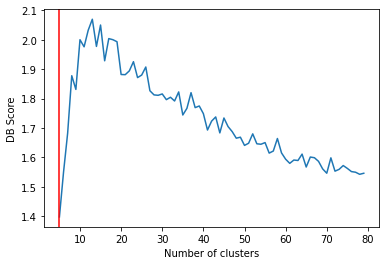

{0, 1, 2, 3, 4}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

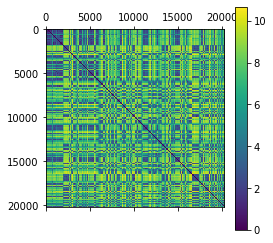

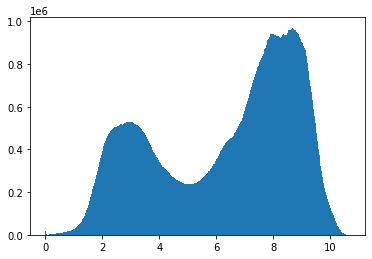

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

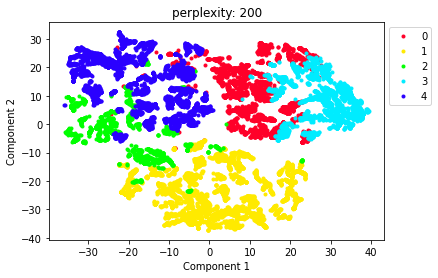

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9707781008229439


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.1720754146346732
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.8653314917127072
layer 4: 0.7417127071823204
layer 5: 0.587189226519337
layer 6: 0.4326657458563536
layer 7: 0.2395113950276243
layer 8: 0.1352080455801105
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.619 | Reg loss: 0.018 | Tree loss: 1.619 | Accuracy: 0.291500 | 1.228 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.603 | Reg loss: 0.017 | Tree loss: 1.603 | Accuracy: 0.307000 | 1.078 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.584 | Reg loss: 0.017 | Tree loss: 1.584 | Accuracy: 0.315000 | 1.072 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.575 | Reg loss: 0.017 | Tree loss: 1.575 | Accuracy: 0.306500 | 1.077 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.560 | Reg loss: 0.016 | Tree loss: 1.560 | Accuracy: 0.312000 | 1.052 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.554 | Reg loss: 0.016 | Tree loss: 1.554 | Accur

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.549 | Reg loss: 0.014 | Tree loss: 1.549 | Accuracy: 0.390500 | 1.066 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.542 | Reg loss: 0.014 | Tree loss: 1.542 | Accuracy: 0.427000 | 1.065 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.522 | Reg loss: 0.014 | Tree loss: 1.522 | Accuracy: 0.515000 | 1.066 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.514 | Reg loss: 0.014 | Tree loss: 1.514 | Accuracy: 0.498500 | 1.064 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.497 | Reg loss: 0.014 | Tree loss: 1.497 | Accuracy: 0.487000 | 1.064 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.480 | Reg loss: 0.015 | Tree loss: 1.480 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 1.491 | Reg loss: 0.016 | Tree loss: 1.491 | Accuracy: 0.557000 | 1.067 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 1.459 | Reg loss: 0.016 | Tree loss: 1.459 | Accuracy: 0.545500 | 1.066 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 1.440 | Reg loss: 0.016 | Tree loss: 1.440 | Accuracy: 0.592000 | 1.067 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.403 | Reg loss: 0.017 | Tree loss: 1.403 | Accuracy: 0.611500 | 1.067 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.372 | Reg loss: 0.017 | Tree loss: 1.372 | Accuracy: 0.603500 | 1.067 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.343 | Reg loss: 0.017 | Tree loss: 1.343 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 1.375 | Reg loss: 0.019 | Tree loss: 1.375 | Accuracy: 0.578500 | 1.068 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 1.355 | Reg loss: 0.019 | Tree loss: 1.355 | Accuracy: 0.578500 | 1.068 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 1.298 | Reg loss: 0.019 | Tree loss: 1.298 | Accuracy: 0.628000 | 1.068 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 1.278 | Reg loss: 0.019 | Tree loss: 1.278 | Accuracy: 0.614500 | 1.068 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 1.235 | Reg loss: 0.019 | Tree loss: 1.235 | Accuracy: 0.629000 | 1.068 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.219 | Reg loss: 0.019 | Tree loss: 1.219 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 1.270 | Reg loss: 0.020 | Tree loss: 1.270 | Accuracy: 0.612500 | 1.067 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 1.237 | Reg loss: 0.020 | Tree loss: 1.237 | Accuracy: 0.612500 | 1.067 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 1.193 | Reg loss: 0.020 | Tree loss: 1.193 | Accuracy: 0.625000 | 1.067 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 1.147 | Reg loss: 0.020 | Tree loss: 1.147 | Accuracy: 0.634000 | 1.067 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 1.133 | Reg loss: 0.021 | Tree loss: 1.133 | Accuracy: 0.608000 | 1.067 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 1.093 | Reg loss: 0.021 | Tree loss: 1.093 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 1.191 | Reg loss: 0.022 | Tree loss: 1.191 | Accuracy: 0.592500 | 1.067 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 1.137 | Reg loss: 0.022 | Tree loss: 1.137 | Accuracy: 0.614000 | 1.067 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 1.129 | Reg loss: 0.022 | Tree loss: 1.129 | Accuracy: 0.618500 | 1.067 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 1.080 | Reg loss: 0.022 | Tree loss: 1.080 | Accuracy: 0.631000 | 1.067 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 1.070 | Reg loss: 0.022 | Tree loss: 1.070 | Accuracy: 0.632000 | 1.066 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 1.015 | Reg loss: 0.022 | Tree loss: 1.015 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 1.097 | Reg loss: 0.022 | Tree loss: 1.097 | Accuracy: 0.621000 | 1.064 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 1.099 | Reg loss: 0.022 | Tree loss: 1.099 | Accuracy: 0.600000 | 1.064 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 1.061 | Reg loss: 0.022 | Tree loss: 1.061 | Accuracy: 0.626000 | 1.064 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 1.038 | Reg loss: 0.023 | Tree loss: 1.038 | Accuracy: 0.613500 | 1.064 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 0.998 | Reg loss: 0.023 | Tree loss: 0.998 | Accuracy: 0.637000 | 1.063 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 0.979 | Reg loss: 0.023 | Tree loss: 0.979 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 1.037 | Reg loss: 0.023 | Tree loss: 1.037 | Accuracy: 0.608500 | 1.063 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 1.038 | Reg loss: 0.023 | Tree loss: 1.038 | Accuracy: 0.612500 | 1.063 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 1.014 | Reg loss: 0.023 | Tree loss: 1.014 | Accuracy: 0.628500 | 1.063 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 0.969 | Reg loss: 0.023 | Tree loss: 0.969 | Accuracy: 0.638000 | 1.063 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 0.972 | Reg loss: 0.023 | Tree loss: 0.972 | Accuracy: 0.624500 | 1.063 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 0.955 | Reg loss: 0.023 | Tree loss: 0.955 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 0.980 | Reg loss: 0.024 | Tree loss: 0.980 | Accuracy: 0.639500 | 1.063 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 0.989 | Reg loss: 0.024 | Tree loss: 0.989 | Accuracy: 0.626000 | 1.063 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 0.968 | Reg loss: 0.024 | Tree loss: 0.968 | Accuracy: 0.639500 | 1.063 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 0.939 | Reg loss: 0.024 | Tree loss: 0.939 | Accuracy: 0.629500 | 1.063 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 0.925 | Reg loss: 0.024 | Tree loss: 0.925 | Accuracy: 0.653000 | 1.063 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 0.893 | Reg loss: 0.024 | Tree loss: 0.893 | A

Epoch: 45 | Batch: 000 / 011 | Total loss: 0.946 | Reg loss: 0.024 | Tree loss: 0.946 | Accuracy: 0.661000 | 1.059 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 0.937 | Reg loss: 0.024 | Tree loss: 0.937 | Accuracy: 0.657500 | 1.058 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 0.945 | Reg loss: 0.024 | Tree loss: 0.945 | Accuracy: 0.639000 | 1.058 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 0.925 | Reg loss: 0.024 | Tree loss: 0.925 | Accuracy: 0.630500 | 1.058 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 0.881 | Reg loss: 0.024 | Tree loss: 0.881 | Accuracy: 0.667000 | 1.058 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 0.871 | Reg loss: 0.024 | Tree loss: 0.871 | Accuracy: 0.659500 | 1.057 sec/iter
Epoch: 45 | Batch: 006 / 011 | Total loss: 0.884 | Reg loss: 0.024 | Tree loss: 0.884 | Accuracy: 0.652000 | 1.057 sec/iter
Epoch: 45 | Batch: 007 / 011 | Total loss: 0.856 | Reg loss: 0.024 | Tree loss: 0.856 | Accuracy: 0.679000 | 1.057 sec/iter
Epoch: 4

Epoch: 50 | Batch: 000 / 011 | Total loss: 0.919 | Reg loss: 0.025 | Tree loss: 0.919 | Accuracy: 0.642500 | 1.044 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 0.912 | Reg loss: 0.025 | Tree loss: 0.912 | Accuracy: 0.654500 | 1.044 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 0.892 | Reg loss: 0.025 | Tree loss: 0.892 | Accuracy: 0.661500 | 1.043 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 0.903 | Reg loss: 0.025 | Tree loss: 0.903 | Accuracy: 0.643500 | 1.043 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 0.877 | Reg loss: 0.025 | Tree loss: 0.877 | Accuracy: 0.654000 | 1.043 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 0.853 | Reg loss: 0.025 | Tree loss: 0.853 | Accuracy: 0.662500 | 1.043 sec/iter
Epoch: 50 | Batch: 006 / 011 | Total loss: 0.850 | Reg loss: 0.025 | Tree loss: 0.850 | Accuracy: 0.664000 | 1.042 sec/iter
Epoch: 50 | Batch: 007 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.665500 | 1.042 sec/iter
Epoch: 5

Epoch: 55 | Batch: 000 / 011 | Total loss: 0.901 | Reg loss: 0.025 | Tree loss: 0.901 | Accuracy: 0.663500 | 1.032 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 0.889 | Reg loss: 0.025 | Tree loss: 0.889 | Accuracy: 0.648000 | 1.031 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 0.898 | Reg loss: 0.025 | Tree loss: 0.898 | Accuracy: 0.642500 | 1.031 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 0.883 | Reg loss: 0.025 | Tree loss: 0.883 | Accuracy: 0.645000 | 1.031 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 0.854 | Reg loss: 0.025 | Tree loss: 0.854 | Accuracy: 0.659000 | 1.031 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 0.833 | Reg loss: 0.025 | Tree loss: 0.833 | Accuracy: 0.674000 | 1.03 sec/iter
Epoch: 55 | Batch: 006 / 011 | Total loss: 0.821 | Reg loss: 0.025 | Tree loss: 0.821 | Accuracy: 0.671500 | 1.03 sec/iter
Epoch: 55 | Batch: 007 / 011 | Total loss: 0.852 | Reg loss: 0.025 | Tree loss: 0.852 | Accuracy: 0.675500 | 1.03 sec/iter
Epoch: 55 |

Epoch: 60 | Batch: 000 / 011 | Total loss: 0.860 | Reg loss: 0.026 | Tree loss: 0.860 | Accuracy: 0.659500 | 1.021 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 0.873 | Reg loss: 0.026 | Tree loss: 0.873 | Accuracy: 0.646500 | 1.021 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 0.864 | Reg loss: 0.026 | Tree loss: 0.864 | Accuracy: 0.653500 | 1.021 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 0.862 | Reg loss: 0.026 | Tree loss: 0.862 | Accuracy: 0.644000 | 1.021 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 0.843 | Reg loss: 0.026 | Tree loss: 0.843 | Accuracy: 0.663500 | 1.021 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 0.832 | Reg loss: 0.026 | Tree loss: 0.832 | Accuracy: 0.662000 | 1.02 sec/iter
Epoch: 60 | Batch: 006 / 011 | Total loss: 0.828 | Reg loss: 0.026 | Tree loss: 0.828 | Accuracy: 0.651500 | 1.02 sec/iter
Epoch: 60 | Batch: 007 / 011 | Total loss: 0.847 | Reg loss: 0.026 | Tree loss: 0.847 | Accuracy: 0.655000 | 1.02 sec/iter
Epoch: 60 |

Epoch: 65 | Batch: 000 / 011 | Total loss: 0.844 | Reg loss: 0.026 | Tree loss: 0.844 | Accuracy: 0.670000 | 1.013 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 0.850 | Reg loss: 0.026 | Tree loss: 0.850 | Accuracy: 0.671000 | 1.013 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 0.890 | Reg loss: 0.026 | Tree loss: 0.890 | Accuracy: 0.628000 | 1.012 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 0.847 | Reg loss: 0.026 | Tree loss: 0.847 | Accuracy: 0.647500 | 1.012 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.843 | Reg loss: 0.026 | Tree loss: 0.843 | Accuracy: 0.655000 | 1.012 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 0.783 | Reg loss: 0.026 | Tree loss: 0.783 | Accuracy: 0.707500 | 1.012 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 0.804 | Reg loss: 0.026 | Tree loss: 0.804 | Accuracy: 0.683000 | 1.012 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 0.784 | Reg loss: 0.026 | Tree loss: 0.784 | Accuracy: 0.695000 | 1.012 sec/iter
Epoch: 6

Epoch: 70 | Batch: 000 / 011 | Total loss: 0.868 | Reg loss: 0.026 | Tree loss: 0.868 | Accuracy: 0.650500 | 1.006 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 0.858 | Reg loss: 0.026 | Tree loss: 0.858 | Accuracy: 0.647000 | 1.005 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 0.832 | Reg loss: 0.026 | Tree loss: 0.832 | Accuracy: 0.657000 | 1.005 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 0.840 | Reg loss: 0.026 | Tree loss: 0.840 | Accuracy: 0.661000 | 1.005 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 0.815 | Reg loss: 0.026 | Tree loss: 0.815 | Accuracy: 0.680000 | 1.005 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 0.814 | Reg loss: 0.026 | Tree loss: 0.814 | Accuracy: 0.679500 | 1.005 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 0.810 | Reg loss: 0.026 | Tree loss: 0.810 | Accuracy: 0.689500 | 1.005 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 0.782 | Reg loss: 0.026 | Tree loss: 0.782 | Accuracy: 0.686500 | 1.005 sec/iter
Epoch: 7

Epoch: 75 | Batch: 000 / 011 | Total loss: 0.866 | Reg loss: 0.026 | Tree loss: 0.866 | Accuracy: 0.646500 | 0.999 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 0.865 | Reg loss: 0.026 | Tree loss: 0.865 | Accuracy: 0.635500 | 0.999 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 0.844 | Reg loss: 0.026 | Tree loss: 0.844 | Accuracy: 0.656500 | 0.999 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 0.823 | Reg loss: 0.026 | Tree loss: 0.823 | Accuracy: 0.684500 | 0.999 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 0.804 | Reg loss: 0.026 | Tree loss: 0.804 | Accuracy: 0.676000 | 0.999 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 0.793 | Reg loss: 0.026 | Tree loss: 0.793 | Accuracy: 0.680000 | 0.999 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 0.783 | Reg loss: 0.026 | Tree loss: 0.783 | Accuracy: 0.688500 | 0.999 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 0.767 | Reg loss: 0.026 | Tree loss: 0.767 | Accuracy: 0.684000 | 0.999 sec/iter
Epoch: 7

Epoch: 80 | Batch: 000 / 011 | Total loss: 0.857 | Reg loss: 0.027 | Tree loss: 0.857 | Accuracy: 0.654000 | 0.994 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 0.847 | Reg loss: 0.027 | Tree loss: 0.847 | Accuracy: 0.652500 | 0.994 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 0.838 | Reg loss: 0.027 | Tree loss: 0.838 | Accuracy: 0.665500 | 0.994 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 0.814 | Reg loss: 0.027 | Tree loss: 0.814 | Accuracy: 0.665000 | 0.994 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 0.810 | Reg loss: 0.027 | Tree loss: 0.810 | Accuracy: 0.668000 | 0.994 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 0.793 | Reg loss: 0.027 | Tree loss: 0.793 | Accuracy: 0.687000 | 0.994 sec/iter
Epoch: 80 | Batch: 006 / 011 | Total loss: 0.782 | Reg loss: 0.027 | Tree loss: 0.782 | Accuracy: 0.670000 | 0.993 sec/iter
Epoch: 80 | Batch: 007 / 011 | Total loss: 0.754 | Reg loss: 0.027 | Tree loss: 0.754 | Accuracy: 0.703000 | 0.993 sec/iter
Epoch: 8

Epoch: 85 | Batch: 000 / 011 | Total loss: 0.839 | Reg loss: 0.027 | Tree loss: 0.839 | Accuracy: 0.663500 | 0.989 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 0.827 | Reg loss: 0.027 | Tree loss: 0.827 | Accuracy: 0.681000 | 0.989 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 0.827 | Reg loss: 0.027 | Tree loss: 0.827 | Accuracy: 0.667000 | 0.989 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 0.806 | Reg loss: 0.027 | Tree loss: 0.806 | Accuracy: 0.679500 | 0.989 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.027 | Tree loss: 0.790 | Accuracy: 0.687000 | 0.989 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 0.787 | Reg loss: 0.027 | Tree loss: 0.787 | Accuracy: 0.694500 | 0.989 sec/iter
Epoch: 85 | Batch: 006 / 011 | Total loss: 0.786 | Reg loss: 0.027 | Tree loss: 0.786 | Accuracy: 0.674500 | 0.989 sec/iter
Epoch: 85 | Batch: 007 / 011 | Total loss: 0.808 | Reg loss: 0.027 | Tree loss: 0.808 | Accuracy: 0.665000 | 0.989 sec/iter
Epoch: 8

Epoch: 90 | Batch: 000 / 011 | Total loss: 0.844 | Reg loss: 0.027 | Tree loss: 0.844 | Accuracy: 0.679000 | 0.985 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 0.823 | Reg loss: 0.027 | Tree loss: 0.823 | Accuracy: 0.660500 | 0.985 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 0.809 | Reg loss: 0.027 | Tree loss: 0.809 | Accuracy: 0.674000 | 0.985 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 0.811 | Reg loss: 0.027 | Tree loss: 0.811 | Accuracy: 0.662500 | 0.985 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.027 | Tree loss: 0.790 | Accuracy: 0.673000 | 0.985 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 0.802 | Reg loss: 0.027 | Tree loss: 0.802 | Accuracy: 0.659500 | 0.985 sec/iter
Epoch: 90 | Batch: 006 / 011 | Total loss: 0.779 | Reg loss: 0.027 | Tree loss: 0.779 | Accuracy: 0.689000 | 0.985 sec/iter
Epoch: 90 | Batch: 007 / 011 | Total loss: 0.759 | Reg loss: 0.027 | Tree loss: 0.759 | Accuracy: 0.681500 | 0.985 sec/iter
Epoch: 9

Epoch: 95 | Batch: 000 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.677500 | 0.981 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 0.830 | Reg loss: 0.027 | Tree loss: 0.830 | Accuracy: 0.673500 | 0.981 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 0.801 | Reg loss: 0.027 | Tree loss: 0.801 | Accuracy: 0.678500 | 0.981 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 0.818 | Reg loss: 0.027 | Tree loss: 0.818 | Accuracy: 0.662000 | 0.981 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 0.776 | Reg loss: 0.027 | Tree loss: 0.776 | Accuracy: 0.685500 | 0.981 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 0.788 | Reg loss: 0.027 | Tree loss: 0.788 | Accuracy: 0.663500 | 0.981 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 0.763 | Reg loss: 0.027 | Tree loss: 0.763 | Accuracy: 0.678500 | 0.981 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 0.781 | Reg loss: 0.027 | Tree loss: 0.781 | Accuracy: 0.667000 | 0.981 sec/iter
Epoch: 9

Epoch: 100 | Batch: 000 / 011 | Total loss: 0.812 | Reg loss: 0.027 | Tree loss: 0.812 | Accuracy: 0.669000 | 0.978 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 0.843 | Reg loss: 0.027 | Tree loss: 0.843 | Accuracy: 0.656500 | 0.978 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 0.810 | Reg loss: 0.027 | Tree loss: 0.810 | Accuracy: 0.680500 | 0.978 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 0.798 | Reg loss: 0.027 | Tree loss: 0.798 | Accuracy: 0.676500 | 0.978 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 0.787 | Reg loss: 0.027 | Tree loss: 0.787 | Accuracy: 0.689000 | 0.978 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 0.785 | Reg loss: 0.027 | Tree loss: 0.785 | Accuracy: 0.678000 | 0.978 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 0.775 | Reg loss: 0.027 | Tree loss: 0.775 | Accuracy: 0.682500 | 0.978 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 0.754 | Reg loss: 0.027 | Tree loss: 0.754 | Accuracy: 0.696500 | 0.977 sec/iter


Epoch: 105 | Batch: 000 / 011 | Total loss: 0.828 | Reg loss: 0.027 | Tree loss: 0.828 | Accuracy: 0.671500 | 0.975 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 0.802 | Reg loss: 0.027 | Tree loss: 0.802 | Accuracy: 0.671000 | 0.975 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 0.811 | Reg loss: 0.027 | Tree loss: 0.811 | Accuracy: 0.653500 | 0.975 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 0.770 | Reg loss: 0.027 | Tree loss: 0.770 | Accuracy: 0.674000 | 0.975 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 0.791 | Reg loss: 0.027 | Tree loss: 0.791 | Accuracy: 0.659000 | 0.974 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 0.811 | Reg loss: 0.027 | Tree loss: 0.811 | Accuracy: 0.665500 | 0.974 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.776 | Reg loss: 0.027 | Tree loss: 0.776 | Accuracy: 0.667000 | 0.974 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.770 | Reg loss: 0.027 | Tree loss: 0.770 | Accuracy: 0.678000 | 0.974 sec/iter


Epoch: 110 | Batch: 000 / 011 | Total loss: 0.827 | Reg loss: 0.027 | Tree loss: 0.827 | Accuracy: 0.666500 | 0.972 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 0.833 | Reg loss: 0.027 | Tree loss: 0.833 | Accuracy: 0.661500 | 0.972 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.674500 | 0.972 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.812 | Reg loss: 0.027 | Tree loss: 0.812 | Accuracy: 0.658000 | 0.972 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.027 | Tree loss: 0.790 | Accuracy: 0.678000 | 0.972 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.758 | Reg loss: 0.027 | Tree loss: 0.758 | Accuracy: 0.675500 | 0.972 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.728 | Reg loss: 0.027 | Tree loss: 0.728 | Accuracy: 0.704500 | 0.972 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.027 | Tree loss: 0.756 | Accuracy: 0.675000 | 0.972 sec/iter


Epoch: 115 | Batch: 000 / 011 | Total loss: 0.825 | Reg loss: 0.027 | Tree loss: 0.825 | Accuracy: 0.679000 | 0.969 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.795 | Reg loss: 0.027 | Tree loss: 0.795 | Accuracy: 0.675500 | 0.969 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.027 | Tree loss: 0.795 | Accuracy: 0.671500 | 0.969 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.781 | Reg loss: 0.027 | Tree loss: 0.781 | Accuracy: 0.671000 | 0.969 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.794 | Reg loss: 0.027 | Tree loss: 0.794 | Accuracy: 0.679000 | 0.969 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.811 | Reg loss: 0.027 | Tree loss: 0.811 | Accuracy: 0.666000 | 0.969 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.735 | Reg loss: 0.027 | Tree loss: 0.735 | Accuracy: 0.696000 | 0.969 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 0.779 | Reg loss: 0.027 | Tree loss: 0.779 | Accuracy: 0.680000 | 0.969 sec/iter


Epoch: 120 | Batch: 000 / 011 | Total loss: 0.820 | Reg loss: 0.027 | Tree loss: 0.820 | Accuracy: 0.674000 | 0.967 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.820 | Reg loss: 0.027 | Tree loss: 0.820 | Accuracy: 0.666000 | 0.967 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.816 | Reg loss: 0.027 | Tree loss: 0.816 | Accuracy: 0.661500 | 0.967 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.027 | Tree loss: 0.778 | Accuracy: 0.685000 | 0.967 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 0.770 | Reg loss: 0.027 | Tree loss: 0.770 | Accuracy: 0.688000 | 0.967 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 0.765 | Reg loss: 0.027 | Tree loss: 0.765 | Accuracy: 0.687000 | 0.967 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 0.761 | Reg loss: 0.027 | Tree loss: 0.761 | Accuracy: 0.694000 | 0.967 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 0.748 | Reg loss: 0.027 | Tree loss: 0.748 | Accuracy: 0.685500 | 0.967 sec/iter


Epoch: 125 | Batch: 000 / 011 | Total loss: 0.813 | Reg loss: 0.027 | Tree loss: 0.813 | Accuracy: 0.678000 | 0.965 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 0.795 | Reg loss: 0.027 | Tree loss: 0.795 | Accuracy: 0.677000 | 0.965 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 0.839 | Reg loss: 0.027 | Tree loss: 0.839 | Accuracy: 0.644000 | 0.965 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 0.787 | Reg loss: 0.027 | Tree loss: 0.787 | Accuracy: 0.683500 | 0.965 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 0.792 | Reg loss: 0.027 | Tree loss: 0.792 | Accuracy: 0.672500 | 0.965 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 0.772 | Reg loss: 0.027 | Tree loss: 0.772 | Accuracy: 0.675000 | 0.965 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 0.763 | Reg loss: 0.027 | Tree loss: 0.763 | Accuracy: 0.678500 | 0.965 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.027 | Tree loss: 0.756 | Accuracy: 0.688500 | 0.965 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 0.801 | Reg loss: 0.027 | Tree loss: 0.801 | Accuracy: 0.675500 | 0.963 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 0.817 | Reg loss: 0.027 | Tree loss: 0.817 | Accuracy: 0.667500 | 0.963 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 0.793 | Reg loss: 0.027 | Tree loss: 0.793 | Accuracy: 0.674500 | 0.963 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 0.798 | Reg loss: 0.027 | Tree loss: 0.798 | Accuracy: 0.669000 | 0.963 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 0.778 | Reg loss: 0.027 | Tree loss: 0.778 | Accuracy: 0.675500 | 0.963 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 0.783 | Reg loss: 0.027 | Tree loss: 0.783 | Accuracy: 0.673500 | 0.963 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 0.762 | Reg loss: 0.027 | Tree loss: 0.762 | Accuracy: 0.679500 | 0.963 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 0.743 | Reg loss: 0.027 | Tree loss: 0.743 | Accuracy: 0.699500 | 0.963 sec/iter


Epoch: 135 | Batch: 000 / 011 | Total loss: 0.820 | Reg loss: 0.027 | Tree loss: 0.820 | Accuracy: 0.666500 | 0.962 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 0.789 | Reg loss: 0.027 | Tree loss: 0.789 | Accuracy: 0.682500 | 0.962 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 0.779 | Reg loss: 0.027 | Tree loss: 0.779 | Accuracy: 0.680500 | 0.962 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 0.792 | Reg loss: 0.027 | Tree loss: 0.792 | Accuracy: 0.687000 | 0.962 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 0.802 | Reg loss: 0.027 | Tree loss: 0.802 | Accuracy: 0.666000 | 0.962 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 0.775 | Reg loss: 0.027 | Tree loss: 0.775 | Accuracy: 0.655000 | 0.962 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 0.741 | Reg loss: 0.027 | Tree loss: 0.741 | Accuracy: 0.702000 | 0.962 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 0.776 | Reg loss: 0.027 | Tree loss: 0.776 | Accuracy: 0.679000 | 0.962 sec/iter


layer 8: 0.9723756906077345
Epoch: 140 | Batch: 000 / 011 | Total loss: 0.813 | Reg loss: 0.027 | Tree loss: 0.813 | Accuracy: 0.679000 | 0.962 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 0.824 | Reg loss: 0.027 | Tree loss: 0.824 | Accuracy: 0.661500 | 0.962 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 0.791 | Reg loss: 0.027 | Tree loss: 0.791 | Accuracy: 0.676000 | 0.962 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 0.773 | Reg loss: 0.027 | Tree loss: 0.773 | Accuracy: 0.673000 | 0.962 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 0.787 | Reg loss: 0.027 | Tree loss: 0.787 | Accuracy: 0.684000 | 0.962 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 0.749 | Reg loss: 0.027 | Tree loss: 0.749 | Accuracy: 0.685500 | 0.962 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 0.751 | Reg loss: 0.027 | Tree loss: 0.751 | Accuracy: 0.694500 | 0.962 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 0.763 | Reg loss: 0.027 | Tree loss: 0.763 | Accuracy

Epoch: 145 | Batch: 000 / 011 | Total loss: 0.786 | Reg loss: 0.027 | Tree loss: 0.786 | Accuracy: 0.680000 | 0.965 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 0.789 | Reg loss: 0.027 | Tree loss: 0.789 | Accuracy: 0.678000 | 0.965 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 0.810 | Reg loss: 0.027 | Tree loss: 0.810 | Accuracy: 0.663000 | 0.965 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 0.770 | Reg loss: 0.027 | Tree loss: 0.770 | Accuracy: 0.675500 | 0.965 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 0.793 | Reg loss: 0.027 | Tree loss: 0.793 | Accuracy: 0.657500 | 0.965 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 0.761 | Reg loss: 0.027 | Tree loss: 0.761 | Accuracy: 0.679500 | 0.965 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 0.786 | Reg loss: 0.027 | Tree loss: 0.786 | Accuracy: 0.670000 | 0.965 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 0.738 | Reg loss: 0.027 | Tree loss: 0.738 | Accuracy: 0.714500 | 0.965 sec/iter


Epoch: 150 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.027 | Tree loss: 0.804 | Accuracy: 0.680000 | 0.969 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 0.823 | Reg loss: 0.027 | Tree loss: 0.823 | Accuracy: 0.650000 | 0.969 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 0.804 | Reg loss: 0.027 | Tree loss: 0.804 | Accuracy: 0.663500 | 0.969 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 0.791 | Reg loss: 0.027 | Tree loss: 0.791 | Accuracy: 0.676000 | 0.97 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 0.789 | Reg loss: 0.027 | Tree loss: 0.789 | Accuracy: 0.670000 | 0.97 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 0.760 | Reg loss: 0.027 | Tree loss: 0.760 | Accuracy: 0.691500 | 0.97 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 0.736 | Reg loss: 0.027 | Tree loss: 0.736 | Accuracy: 0.705500 | 0.971 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.027 | Tree loss: 0.756 | Accuracy: 0.694500 | 0.971 sec/iter
Epo

Epoch: 155 | Batch: 000 / 011 | Total loss: 0.809 | Reg loss: 0.027 | Tree loss: 0.809 | Accuracy: 0.674500 | 0.985 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 0.802 | Reg loss: 0.027 | Tree loss: 0.802 | Accuracy: 0.673500 | 0.985 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 0.807 | Reg loss: 0.027 | Tree loss: 0.807 | Accuracy: 0.677500 | 0.985 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 0.783 | Reg loss: 0.027 | Tree loss: 0.783 | Accuracy: 0.690000 | 0.985 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 0.766 | Reg loss: 0.027 | Tree loss: 0.766 | Accuracy: 0.680000 | 0.986 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 0.768 | Reg loss: 0.027 | Tree loss: 0.768 | Accuracy: 0.680500 | 0.986 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 0.729 | Reg loss: 0.027 | Tree loss: 0.729 | Accuracy: 0.709000 | 0.986 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 0.761 | Reg loss: 0.027 | Tree loss: 0.761 | Accuracy: 0.699000 | 0.987 sec/iter


Epoch: 160 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.027 | Tree loss: 0.804 | Accuracy: 0.680500 | 1.0 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 0.814 | Reg loss: 0.027 | Tree loss: 0.814 | Accuracy: 0.675000 | 1.0 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 0.781 | Reg loss: 0.027 | Tree loss: 0.781 | Accuracy: 0.680500 | 1.0 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 0.779 | Reg loss: 0.027 | Tree loss: 0.779 | Accuracy: 0.673500 | 1.001 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 0.761 | Reg loss: 0.027 | Tree loss: 0.761 | Accuracy: 0.689000 | 1.001 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 0.782 | Reg loss: 0.027 | Tree loss: 0.782 | Accuracy: 0.673500 | 1.001 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 0.748 | Reg loss: 0.027 | Tree loss: 0.748 | Accuracy: 0.696000 | 1.002 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 0.757 | Reg loss: 0.027 | Tree loss: 0.757 | Accuracy: 0.686500 | 1.002 sec/iter
Epoch:

Epoch: 165 | Batch: 000 / 011 | Total loss: 0.829 | Reg loss: 0.027 | Tree loss: 0.829 | Accuracy: 0.663500 | 1.016 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 0.777 | Reg loss: 0.027 | Tree loss: 0.777 | Accuracy: 0.693500 | 1.016 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 0.800 | Reg loss: 0.027 | Tree loss: 0.800 | Accuracy: 0.671000 | 1.016 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 0.764 | Reg loss: 0.027 | Tree loss: 0.764 | Accuracy: 0.677500 | 1.017 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 0.804 | Reg loss: 0.027 | Tree loss: 0.804 | Accuracy: 0.665500 | 1.017 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 0.759 | Reg loss: 0.027 | Tree loss: 0.759 | Accuracy: 0.675000 | 1.017 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 0.749 | Reg loss: 0.027 | Tree loss: 0.749 | Accuracy: 0.696500 | 1.018 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 0.739 | Reg loss: 0.027 | Tree loss: 0.739 | Accuracy: 0.695000 | 1.018 sec/iter


Epoch: 170 | Batch: 000 / 011 | Total loss: 0.803 | Reg loss: 0.027 | Tree loss: 0.803 | Accuracy: 0.672500 | 1.03 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 0.791 | Reg loss: 0.027 | Tree loss: 0.791 | Accuracy: 0.676000 | 1.03 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 0.781 | Reg loss: 0.027 | Tree loss: 0.781 | Accuracy: 0.687500 | 1.031 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 0.781 | Reg loss: 0.027 | Tree loss: 0.781 | Accuracy: 0.681000 | 1.031 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 0.752 | Reg loss: 0.027 | Tree loss: 0.752 | Accuracy: 0.686500 | 1.031 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 0.761 | Reg loss: 0.027 | Tree loss: 0.761 | Accuracy: 0.688500 | 1.031 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 0.755 | Reg loss: 0.027 | Tree loss: 0.755 | Accuracy: 0.711500 | 1.031 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 0.751 | Reg loss: 0.027 | Tree loss: 0.751 | Accuracy: 0.701500 | 1.031 sec/iter
Ep

Epoch: 175 | Batch: 000 / 011 | Total loss: 0.797 | Reg loss: 0.027 | Tree loss: 0.797 | Accuracy: 0.674000 | 1.044 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 0.807 | Reg loss: 0.027 | Tree loss: 0.807 | Accuracy: 0.680000 | 1.044 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 0.771 | Reg loss: 0.027 | Tree loss: 0.771 | Accuracy: 0.692500 | 1.045 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 0.774 | Reg loss: 0.027 | Tree loss: 0.774 | Accuracy: 0.665000 | 1.045 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 0.771 | Reg loss: 0.027 | Tree loss: 0.771 | Accuracy: 0.674500 | 1.045 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 0.743 | Reg loss: 0.027 | Tree loss: 0.743 | Accuracy: 0.705500 | 1.045 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 0.786 | Reg loss: 0.027 | Tree loss: 0.786 | Accuracy: 0.676000 | 1.046 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 0.739 | Reg loss: 0.027 | Tree loss: 0.739 | Accuracy: 0.706500 | 1.046 sec/iter


Epoch: 180 | Batch: 000 / 011 | Total loss: 0.808 | Reg loss: 0.027 | Tree loss: 0.808 | Accuracy: 0.675500 | 1.058 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 0.807 | Reg loss: 0.027 | Tree loss: 0.807 | Accuracy: 0.675500 | 1.058 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 0.777 | Reg loss: 0.027 | Tree loss: 0.777 | Accuracy: 0.686000 | 1.058 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.027 | Tree loss: 0.778 | Accuracy: 0.682000 | 1.059 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 0.740 | Reg loss: 0.027 | Tree loss: 0.740 | Accuracy: 0.710000 | 1.059 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 0.760 | Reg loss: 0.027 | Tree loss: 0.760 | Accuracy: 0.695000 | 1.059 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 0.765 | Reg loss: 0.027 | Tree loss: 0.765 | Accuracy: 0.693500 | 1.06 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 0.745 | Reg loss: 0.027 | Tree loss: 0.745 | Accuracy: 0.716500 | 1.06 sec/iter
Ep

Epoch: 185 | Batch: 000 / 011 | Total loss: 0.784 | Reg loss: 0.027 | Tree loss: 0.784 | Accuracy: 0.682500 | 1.071 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 0.817 | Reg loss: 0.027 | Tree loss: 0.817 | Accuracy: 0.676000 | 1.071 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 0.796 | Reg loss: 0.027 | Tree loss: 0.796 | Accuracy: 0.673500 | 1.071 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 0.773 | Reg loss: 0.027 | Tree loss: 0.773 | Accuracy: 0.672500 | 1.071 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.027 | Tree loss: 0.767 | Accuracy: 0.671500 | 1.072 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 0.756 | Reg loss: 0.027 | Tree loss: 0.756 | Accuracy: 0.682000 | 1.072 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 0.748 | Reg loss: 0.027 | Tree loss: 0.748 | Accuracy: 0.695000 | 1.072 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 0.782 | Reg loss: 0.027 | Tree loss: 0.782 | Accuracy: 0.697000 | 1.072 sec/iter


Epoch: 190 | Batch: 000 / 011 | Total loss: 0.819 | Reg loss: 0.027 | Tree loss: 0.819 | Accuracy: 0.661000 | 1.083 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 0.808 | Reg loss: 0.027 | Tree loss: 0.808 | Accuracy: 0.661000 | 1.083 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 0.794 | Reg loss: 0.027 | Tree loss: 0.794 | Accuracy: 0.672000 | 1.084 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 0.766 | Reg loss: 0.027 | Tree loss: 0.766 | Accuracy: 0.678500 | 1.084 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 0.746 | Reg loss: 0.027 | Tree loss: 0.746 | Accuracy: 0.674500 | 1.084 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 0.741 | Reg loss: 0.027 | Tree loss: 0.741 | Accuracy: 0.691000 | 1.084 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 0.749 | Reg loss: 0.027 | Tree loss: 0.749 | Accuracy: 0.702000 | 1.084 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 0.745 | Reg loss: 0.027 | Tree loss: 0.745 | Accuracy: 0.715500 | 1.084 sec/iter


Epoch: 195 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.027 | Tree loss: 0.804 | Accuracy: 0.671000 | 1.095 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 0.802 | Reg loss: 0.027 | Tree loss: 0.802 | Accuracy: 0.670000 | 1.095 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 0.782 | Reg loss: 0.027 | Tree loss: 0.782 | Accuracy: 0.680500 | 1.095 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 0.764 | Reg loss: 0.027 | Tree loss: 0.764 | Accuracy: 0.667000 | 1.095 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 0.766 | Reg loss: 0.027 | Tree loss: 0.766 | Accuracy: 0.679000 | 1.095 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 0.768 | Reg loss: 0.027 | Tree loss: 0.768 | Accuracy: 0.682000 | 1.096 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 0.760 | Reg loss: 0.027 | Tree loss: 0.760 | Accuracy: 0.699500 | 1.096 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 0.755 | Reg loss: 0.027 | Tree loss: 0.755 | Accuracy: 0.692000 | 1.096 sec/iter


Epoch: 200 | Batch: 000 / 011 | Total loss: 0.796 | Reg loss: 0.027 | Tree loss: 0.796 | Accuracy: 0.667500 | 1.097 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 0.822 | Reg loss: 0.027 | Tree loss: 0.822 | Accuracy: 0.670000 | 1.097 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 0.786 | Reg loss: 0.027 | Tree loss: 0.786 | Accuracy: 0.672000 | 1.096 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 0.760 | Reg loss: 0.027 | Tree loss: 0.760 | Accuracy: 0.698500 | 1.096 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 0.773 | Reg loss: 0.027 | Tree loss: 0.773 | Accuracy: 0.688000 | 1.096 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 0.762 | Reg loss: 0.027 | Tree loss: 0.762 | Accuracy: 0.695500 | 1.096 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 0.736 | Reg loss: 0.027 | Tree loss: 0.736 | Accuracy: 0.710000 | 1.096 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 0.761 | Reg loss: 0.027 | Tree loss: 0.761 | Accuracy: 0.715500 | 1.096 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 0.811 | Reg loss: 0.027 | Tree loss: 0.811 | Accuracy: 0.655000 | 1.093 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 0.783 | Reg loss: 0.027 | Tree loss: 0.783 | Accuracy: 0.652500 | 1.093 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.027 | Tree loss: 0.795 | Accuracy: 0.670500 | 1.093 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 0.776 | Reg loss: 0.027 | Tree loss: 0.776 | Accuracy: 0.686500 | 1.093 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 0.771 | Reg loss: 0.027 | Tree loss: 0.771 | Accuracy: 0.662500 | 1.093 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 0.746 | Reg loss: 0.027 | Tree loss: 0.746 | Accuracy: 0.704500 | 1.093 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 0.756 | Reg loss: 0.027 | Tree loss: 0.756 | Accuracy: 0.711000 | 1.093 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 0.763 | Reg loss: 0.027 | Tree loss: 0.763 | Accuracy: 0.710000 | 1.093 sec/iter


Epoch: 210 | Batch: 000 / 011 | Total loss: 0.816 | Reg loss: 0.027 | Tree loss: 0.816 | Accuracy: 0.659000 | 1.091 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 0.786 | Reg loss: 0.027 | Tree loss: 0.786 | Accuracy: 0.662000 | 1.091 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 0.779 | Reg loss: 0.027 | Tree loss: 0.779 | Accuracy: 0.693500 | 1.091 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.027 | Tree loss: 0.778 | Accuracy: 0.680000 | 1.091 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 0.768 | Reg loss: 0.027 | Tree loss: 0.768 | Accuracy: 0.691500 | 1.091 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.027 | Tree loss: 0.734 | Accuracy: 0.682500 | 1.091 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 0.755 | Reg loss: 0.027 | Tree loss: 0.755 | Accuracy: 0.687500 | 1.091 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 0.759 | Reg loss: 0.027 | Tree loss: 0.759 | Accuracy: 0.689000 | 1.091 sec/iter


Epoch: 215 | Batch: 000 / 011 | Total loss: 0.810 | Reg loss: 0.027 | Tree loss: 0.810 | Accuracy: 0.654000 | 1.089 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 0.790 | Reg loss: 0.027 | Tree loss: 0.790 | Accuracy: 0.674000 | 1.089 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 0.793 | Reg loss: 0.027 | Tree loss: 0.793 | Accuracy: 0.659500 | 1.089 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 0.785 | Reg loss: 0.027 | Tree loss: 0.785 | Accuracy: 0.670000 | 1.089 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 0.775 | Reg loss: 0.027 | Tree loss: 0.775 | Accuracy: 0.671000 | 1.089 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 0.764 | Reg loss: 0.027 | Tree loss: 0.764 | Accuracy: 0.667500 | 1.089 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 0.738 | Reg loss: 0.027 | Tree loss: 0.738 | Accuracy: 0.698500 | 1.089 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 0.745 | Reg loss: 0.027 | Tree loss: 0.745 | Accuracy: 0.695500 | 1.089 sec/iter


Epoch: 220 | Batch: 000 / 011 | Total loss: 0.800 | Reg loss: 0.027 | Tree loss: 0.800 | Accuracy: 0.674500 | 1.088 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 0.803 | Reg loss: 0.027 | Tree loss: 0.803 | Accuracy: 0.671500 | 1.087 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 0.790 | Reg loss: 0.027 | Tree loss: 0.790 | Accuracy: 0.667500 | 1.087 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 0.774 | Reg loss: 0.027 | Tree loss: 0.774 | Accuracy: 0.677000 | 1.087 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 0.755 | Reg loss: 0.027 | Tree loss: 0.755 | Accuracy: 0.682500 | 1.087 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.027 | Tree loss: 0.734 | Accuracy: 0.700000 | 1.087 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 0.739 | Reg loss: 0.027 | Tree loss: 0.739 | Accuracy: 0.694500 | 1.087 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 0.764 | Reg loss: 0.027 | Tree loss: 0.764 | Accuracy: 0.699500 | 1.087 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 0.795 | Reg loss: 0.027 | Tree loss: 0.795 | Accuracy: 0.667500 | 1.086 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 0.809 | Reg loss: 0.027 | Tree loss: 0.809 | Accuracy: 0.679000 | 1.086 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 0.803 | Reg loss: 0.027 | Tree loss: 0.803 | Accuracy: 0.669000 | 1.086 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 0.762 | Reg loss: 0.027 | Tree loss: 0.762 | Accuracy: 0.679500 | 1.086 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 0.757 | Reg loss: 0.027 | Tree loss: 0.757 | Accuracy: 0.700000 | 1.086 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 0.730 | Reg loss: 0.027 | Tree loss: 0.730 | Accuracy: 0.712000 | 1.086 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 0.778 | Reg loss: 0.027 | Tree loss: 0.778 | Accuracy: 0.681000 | 1.086 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 0.744 | Reg loss: 0.027 | Tree loss: 0.744 | Accuracy: 0.709500 | 1.085 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 0.805 | Reg loss: 0.027 | Tree loss: 0.805 | Accuracy: 0.672000 | 1.084 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 0.794 | Reg loss: 0.027 | Tree loss: 0.794 | Accuracy: 0.663500 | 1.084 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.027 | Tree loss: 0.795 | Accuracy: 0.667500 | 1.084 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 0.780 | Reg loss: 0.027 | Tree loss: 0.780 | Accuracy: 0.671000 | 1.084 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.027 | Tree loss: 0.790 | Accuracy: 0.668500 | 1.084 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 0.730 | Reg loss: 0.027 | Tree loss: 0.730 | Accuracy: 0.681000 | 1.084 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 0.750 | Reg loss: 0.027 | Tree loss: 0.750 | Accuracy: 0.685000 | 1.084 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 0.758 | Reg loss: 0.027 | Tree loss: 0.758 | Accuracy: 0.700000 | 1.084 sec/iter


Epoch: 235 | Batch: 000 / 011 | Total loss: 0.810 | Reg loss: 0.027 | Tree loss: 0.810 | Accuracy: 0.665000 | 1.082 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 0.807 | Reg loss: 0.027 | Tree loss: 0.807 | Accuracy: 0.665500 | 1.082 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 0.815 | Reg loss: 0.027 | Tree loss: 0.815 | Accuracy: 0.659500 | 1.082 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 0.792 | Reg loss: 0.027 | Tree loss: 0.792 | Accuracy: 0.664000 | 1.082 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 0.744 | Reg loss: 0.027 | Tree loss: 0.744 | Accuracy: 0.686500 | 1.082 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 0.743 | Reg loss: 0.028 | Tree loss: 0.743 | Accuracy: 0.697000 | 1.082 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.695500 | 1.082 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.710500 | 1.082 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 0.799 | Reg loss: 0.027 | Tree loss: 0.799 | Accuracy: 0.673000 | 1.081 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 0.792 | Reg loss: 0.027 | Tree loss: 0.792 | Accuracy: 0.664500 | 1.081 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 0.817 | Reg loss: 0.027 | Tree loss: 0.817 | Accuracy: 0.639000 | 1.081 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 0.797 | Reg loss: 0.027 | Tree loss: 0.797 | Accuracy: 0.672500 | 1.081 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 0.749 | Reg loss: 0.027 | Tree loss: 0.749 | Accuracy: 0.691500 | 1.081 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 0.756 | Reg loss: 0.028 | Tree loss: 0.756 | Accuracy: 0.675000 | 1.081 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 0.721 | Reg loss: 0.028 | Tree loss: 0.721 | Accuracy: 0.709000 | 1.081 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 0.749 | Reg loss: 0.028 | Tree loss: 0.749 | Accuracy: 0.697500 | 1.081 sec/iter


Epoch: 245 | Batch: 000 / 011 | Total loss: 0.823 | Reg loss: 0.027 | Tree loss: 0.823 | Accuracy: 0.657500 | 1.079 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 0.806 | Reg loss: 0.027 | Tree loss: 0.806 | Accuracy: 0.653500 | 1.079 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 0.782 | Reg loss: 0.027 | Tree loss: 0.782 | Accuracy: 0.669000 | 1.079 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 0.791 | Reg loss: 0.027 | Tree loss: 0.791 | Accuracy: 0.671500 | 1.079 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 0.763 | Reg loss: 0.027 | Tree loss: 0.763 | Accuracy: 0.669000 | 1.079 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 0.722 | Reg loss: 0.028 | Tree loss: 0.722 | Accuracy: 0.700000 | 1.079 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.692500 | 1.079 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.718000 | 1.079 sec/iter


Epoch: 250 | Batch: 000 / 011 | Total loss: 0.821 | Reg loss: 0.027 | Tree loss: 0.821 | Accuracy: 0.658500 | 1.078 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 0.789 | Reg loss: 0.027 | Tree loss: 0.789 | Accuracy: 0.678500 | 1.078 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.668500 | 1.078 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 0.756 | Reg loss: 0.028 | Tree loss: 0.756 | Accuracy: 0.681500 | 1.078 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 0.735 | Reg loss: 0.028 | Tree loss: 0.735 | Accuracy: 0.693500 | 1.077 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 0.768 | Reg loss: 0.028 | Tree loss: 0.768 | Accuracy: 0.687000 | 1.077 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 0.760 | Reg loss: 0.028 | Tree loss: 0.760 | Accuracy: 0.693500 | 1.077 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.686500 | 1.077 sec/iter


Epoch: 255 | Batch: 000 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.666500 | 1.074 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 0.795 | Reg loss: 0.028 | Tree loss: 0.795 | Accuracy: 0.662000 | 1.074 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.663500 | 1.074 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 0.795 | Reg loss: 0.028 | Tree loss: 0.795 | Accuracy: 0.668000 | 1.074 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 0.743 | Reg loss: 0.028 | Tree loss: 0.743 | Accuracy: 0.698500 | 1.074 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.686000 | 1.074 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 0.730 | Reg loss: 0.028 | Tree loss: 0.730 | Accuracy: 0.723500 | 1.074 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.693000 | 1.074 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 0.826 | Reg loss: 0.028 | Tree loss: 0.826 | Accuracy: 0.641500 | 1.071 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 0.826 | Reg loss: 0.028 | Tree loss: 0.826 | Accuracy: 0.645500 | 1.071 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.677000 | 1.071 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 0.761 | Reg loss: 0.028 | Tree loss: 0.761 | Accuracy: 0.693500 | 1.071 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 0.752 | Reg loss: 0.028 | Tree loss: 0.752 | Accuracy: 0.699500 | 1.071 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 0.737 | Reg loss: 0.028 | Tree loss: 0.737 | Accuracy: 0.709000 | 1.071 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 0.772 | Reg loss: 0.028 | Tree loss: 0.772 | Accuracy: 0.693500 | 1.071 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.700500 | 1.071 sec/iter


Epoch: 265 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.662500 | 1.068 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.676500 | 1.068 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.669000 | 1.068 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.689500 | 1.068 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.663500 | 1.068 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 0.742 | Reg loss: 0.028 | Tree loss: 0.742 | Accuracy: 0.700500 | 1.068 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.683500 | 1.068 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 0.760 | Reg loss: 0.028 | Tree loss: 0.760 | Accuracy: 0.712000 | 1.068 sec/iter


Epoch: 270 | Batch: 000 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.650000 | 1.065 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.682500 | 1.065 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.664000 | 1.065 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 0.773 | Reg loss: 0.028 | Tree loss: 0.773 | Accuracy: 0.690500 | 1.065 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.681000 | 1.065 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 0.757 | Reg loss: 0.028 | Tree loss: 0.757 | Accuracy: 0.689500 | 1.065 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 0.765 | Reg loss: 0.028 | Tree loss: 0.765 | Accuracy: 0.683000 | 1.065 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.684500 | 1.065 sec/iter


Epoch: 275 | Batch: 000 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.663000 | 1.063 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.661500 | 1.063 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.668000 | 1.063 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.685000 | 1.063 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 0.766 | Reg loss: 0.028 | Tree loss: 0.766 | Accuracy: 0.687500 | 1.062 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 0.737 | Reg loss: 0.028 | Tree loss: 0.737 | Accuracy: 0.699000 | 1.062 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.716000 | 1.062 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 0.727 | Reg loss: 0.028 | Tree loss: 0.727 | Accuracy: 0.704500 | 1.062 sec/iter


Epoch: 280 | Batch: 000 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.657000 | 1.06 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 0.818 | Reg loss: 0.028 | Tree loss: 0.818 | Accuracy: 0.653500 | 1.06 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.681500 | 1.06 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 0.766 | Reg loss: 0.028 | Tree loss: 0.766 | Accuracy: 0.685000 | 1.06 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 0.753 | Reg loss: 0.028 | Tree loss: 0.753 | Accuracy: 0.689000 | 1.06 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 0.729 | Reg loss: 0.028 | Tree loss: 0.729 | Accuracy: 0.707500 | 1.06 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 0.754 | Reg loss: 0.028 | Tree loss: 0.754 | Accuracy: 0.688500 | 1.06 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.684000 | 1.06 sec/iter
Epoch: 2

Epoch: 285 | Batch: 000 / 011 | Total loss: 0.831 | Reg loss: 0.028 | Tree loss: 0.831 | Accuracy: 0.637500 | 1.057 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.657500 | 1.057 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.673000 | 1.057 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.688500 | 1.057 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 0.754 | Reg loss: 0.028 | Tree loss: 0.754 | Accuracy: 0.687500 | 1.057 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 0.745 | Reg loss: 0.028 | Tree loss: 0.745 | Accuracy: 0.693500 | 1.057 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 0.743 | Reg loss: 0.028 | Tree loss: 0.743 | Accuracy: 0.701000 | 1.057 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 0.732 | Reg loss: 0.028 | Tree loss: 0.732 | Accuracy: 0.707000 | 1.057 sec/iter


Epoch: 290 | Batch: 000 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.661500 | 1.055 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 0.821 | Reg loss: 0.028 | Tree loss: 0.821 | Accuracy: 0.635000 | 1.055 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.652000 | 1.055 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.028 | Tree loss: 0.778 | Accuracy: 0.689500 | 1.055 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.691500 | 1.055 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.028 | Tree loss: 0.734 | Accuracy: 0.694000 | 1.055 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 0.748 | Reg loss: 0.028 | Tree loss: 0.748 | Accuracy: 0.712000 | 1.055 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 0.745 | Reg loss: 0.028 | Tree loss: 0.745 | Accuracy: 0.712000 | 1.055 sec/iter


Epoch: 295 | Batch: 000 / 011 | Total loss: 0.816 | Reg loss: 0.028 | Tree loss: 0.816 | Accuracy: 0.669000 | 1.053 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 0.834 | Reg loss: 0.028 | Tree loss: 0.834 | Accuracy: 0.669500 | 1.052 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.667000 | 1.052 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 0.765 | Reg loss: 0.028 | Tree loss: 0.765 | Accuracy: 0.688500 | 1.052 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.686500 | 1.052 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.705500 | 1.052 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 0.748 | Reg loss: 0.028 | Tree loss: 0.748 | Accuracy: 0.714500 | 1.052 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 0.722 | Reg loss: 0.028 | Tree loss: 0.722 | Accuracy: 0.720500 | 1.052 sec/iter


Epoch: 300 | Batch: 000 / 011 | Total loss: 0.825 | Reg loss: 0.028 | Tree loss: 0.825 | Accuracy: 0.639000 | 1.05 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.691500 | 1.05 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.677000 | 1.05 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.028 | Tree loss: 0.778 | Accuracy: 0.700500 | 1.05 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 0.749 | Reg loss: 0.028 | Tree loss: 0.749 | Accuracy: 0.687000 | 1.05 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 0.736 | Reg loss: 0.028 | Tree loss: 0.736 | Accuracy: 0.701000 | 1.05 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 0.757 | Reg loss: 0.028 | Tree loss: 0.757 | Accuracy: 0.701500 | 1.05 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 0.765 | Reg loss: 0.028 | Tree loss: 0.765 | Accuracy: 0.691000 | 1.05 sec/iter
Epoch: 3

Epoch: 305 | Batch: 000 / 011 | Total loss: 0.812 | Reg loss: 0.028 | Tree loss: 0.812 | Accuracy: 0.657500 | 1.048 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.675500 | 1.048 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.679000 | 1.048 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.678000 | 1.048 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.671500 | 1.048 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 0.723 | Reg loss: 0.028 | Tree loss: 0.723 | Accuracy: 0.696500 | 1.048 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.682500 | 1.048 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 0.734 | Reg loss: 0.028 | Tree loss: 0.734 | Accuracy: 0.716500 | 1.048 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 0.818 | Reg loss: 0.028 | Tree loss: 0.818 | Accuracy: 0.649500 | 1.046 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.661000 | 1.046 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.674000 | 1.046 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.689000 | 1.046 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.681000 | 1.046 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 0.742 | Reg loss: 0.028 | Tree loss: 0.742 | Accuracy: 0.686000 | 1.046 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 0.747 | Reg loss: 0.028 | Tree loss: 0.747 | Accuracy: 0.705000 | 1.046 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 0.741 | Reg loss: 0.028 | Tree loss: 0.741 | Accuracy: 0.718000 | 1.046 sec/iter


Epoch: 315 | Batch: 000 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.662000 | 1.044 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.661500 | 1.044 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.674000 | 1.044 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.673500 | 1.044 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.694500 | 1.044 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 0.762 | Reg loss: 0.028 | Tree loss: 0.762 | Accuracy: 0.683000 | 1.044 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 0.751 | Reg loss: 0.028 | Tree loss: 0.751 | Accuracy: 0.693500 | 1.044 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.705000 | 1.044 sec/iter


Epoch: 320 | Batch: 000 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.651000 | 1.042 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 0.818 | Reg loss: 0.028 | Tree loss: 0.818 | Accuracy: 0.645000 | 1.042 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.663500 | 1.042 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 0.790 | Reg loss: 0.028 | Tree loss: 0.790 | Accuracy: 0.679500 | 1.042 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 0.757 | Reg loss: 0.028 | Tree loss: 0.757 | Accuracy: 0.687000 | 1.042 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 0.761 | Reg loss: 0.028 | Tree loss: 0.761 | Accuracy: 0.688500 | 1.042 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 0.736 | Reg loss: 0.028 | Tree loss: 0.736 | Accuracy: 0.710000 | 1.042 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 0.744 | Reg loss: 0.028 | Tree loss: 0.744 | Accuracy: 0.710000 | 1.042 sec/iter


Epoch: 325 | Batch: 000 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.663500 | 1.04 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.656000 | 1.04 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.679500 | 1.04 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.678000 | 1.04 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.670500 | 1.04 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 0.751 | Reg loss: 0.028 | Tree loss: 0.751 | Accuracy: 0.686500 | 1.04 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 0.753 | Reg loss: 0.028 | Tree loss: 0.753 | Accuracy: 0.702000 | 1.04 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 0.741 | Reg loss: 0.028 | Tree loss: 0.741 | Accuracy: 0.704500 | 1.04 sec/iter
Epoch: 3

Epoch: 330 | Batch: 000 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.677500 | 1.039 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 0.800 | Reg loss: 0.028 | Tree loss: 0.800 | Accuracy: 0.671500 | 1.039 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.657000 | 1.039 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.678500 | 1.039 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.685500 | 1.039 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.028 | Tree loss: 0.734 | Accuracy: 0.695500 | 1.039 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 0.737 | Reg loss: 0.028 | Tree loss: 0.737 | Accuracy: 0.705000 | 1.039 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.682500 | 1.039 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.674000 | 1.037 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.668500 | 1.037 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.673000 | 1.037 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.668000 | 1.037 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 0.764 | Reg loss: 0.028 | Tree loss: 0.764 | Accuracy: 0.685500 | 1.037 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 0.771 | Reg loss: 0.028 | Tree loss: 0.771 | Accuracy: 0.689000 | 1.037 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 0.736 | Reg loss: 0.028 | Tree loss: 0.736 | Accuracy: 0.705000 | 1.037 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.709000 | 1.037 sec/iter


Epoch: 340 | Batch: 000 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.663000 | 1.036 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.670500 | 1.035 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.684500 | 1.035 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 0.760 | Reg loss: 0.028 | Tree loss: 0.760 | Accuracy: 0.682500 | 1.035 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 0.768 | Reg loss: 0.028 | Tree loss: 0.768 | Accuracy: 0.681500 | 1.035 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 0.768 | Reg loss: 0.028 | Tree loss: 0.768 | Accuracy: 0.672500 | 1.035 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.750 | Reg loss: 0.028 | Tree loss: 0.750 | Accuracy: 0.696000 | 1.035 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.748 | Reg loss: 0.028 | Tree loss: 0.748 | Accuracy: 0.701500 | 1.035 sec/iter


layer 8: 0.9723756906077345
Epoch: 345 | Batch: 000 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.653500 | 1.035 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.673000 | 1.035 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.676000 | 1.035 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.662000 | 1.035 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.658500 | 1.035 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.674500 | 1.035 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.700500 | 1.035 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 0.733 | Reg loss: 0.028 | Tree loss: 0.733 | Accuracy

layer 8: 0.9723756906077345
Epoch: 350 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.661000 | 1.035 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 0.810 | Reg loss: 0.028 | Tree loss: 0.810 | Accuracy: 0.659500 | 1.035 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.664500 | 1.035 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.673500 | 1.035 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 0.761 | Reg loss: 0.028 | Tree loss: 0.761 | Accuracy: 0.672500 | 1.035 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 0.761 | Reg loss: 0.028 | Tree loss: 0.761 | Accuracy: 0.683500 | 1.035 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 0.741 | Reg loss: 0.028 | Tree loss: 0.741 | Accuracy: 0.697500 | 1.035 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 0.752 | Reg loss: 0.028 | Tree loss: 0.752 | Accuracy

Epoch: 355 | Batch: 000 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.670000 | 1.038 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 0.782 | Reg loss: 0.028 | Tree loss: 0.782 | Accuracy: 0.674000 | 1.038 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.677000 | 1.038 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.678500 | 1.038 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 0.741 | Reg loss: 0.028 | Tree loss: 0.741 | Accuracy: 0.694500 | 1.039 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.673500 | 1.039 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 0.728 | Reg loss: 0.028 | Tree loss: 0.728 | Accuracy: 0.709500 | 1.039 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 0.742 | Reg loss: 0.028 | Tree loss: 0.742 | Accuracy: 0.695500 | 1.039 sec/iter


Epoch: 360 | Batch: 000 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.676000 | 1.044 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.666000 | 1.044 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.682500 | 1.044 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 0.754 | Reg loss: 0.028 | Tree loss: 0.754 | Accuracy: 0.688000 | 1.044 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 0.762 | Reg loss: 0.028 | Tree loss: 0.762 | Accuracy: 0.688500 | 1.044 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 0.747 | Reg loss: 0.028 | Tree loss: 0.747 | Accuracy: 0.701000 | 1.044 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.684000 | 1.045 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 0.747 | Reg loss: 0.028 | Tree loss: 0.747 | Accuracy: 0.703500 | 1.045 sec/iter


Epoch: 365 | Batch: 000 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.670000 | 1.05 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 0.800 | Reg loss: 0.028 | Tree loss: 0.800 | Accuracy: 0.675500 | 1.05 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.663500 | 1.05 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.696500 | 1.051 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.682000 | 1.051 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.662500 | 1.051 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.676500 | 1.051 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 0.742 | Reg loss: 0.028 | Tree loss: 0.742 | Accuracy: 0.718500 | 1.051 sec/iter
Epo

Epoch: 370 | Batch: 000 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.667500 | 1.057 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 0.797 | Reg loss: 0.028 | Tree loss: 0.797 | Accuracy: 0.666500 | 1.057 sec/iter
Epoch: 370 | Batch: 002 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.681500 | 1.057 sec/iter
Epoch: 370 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.028 | Tree loss: 0.778 | Accuracy: 0.690000 | 1.057 sec/iter
Epoch: 370 | Batch: 004 / 011 | Total loss: 0.747 | Reg loss: 0.028 | Tree loss: 0.747 | Accuracy: 0.684000 | 1.057 sec/iter
Epoch: 370 | Batch: 005 / 011 | Total loss: 0.765 | Reg loss: 0.028 | Tree loss: 0.765 | Accuracy: 0.679500 | 1.057 sec/iter
Epoch: 370 | Batch: 006 / 011 | Total loss: 0.773 | Reg loss: 0.028 | Tree loss: 0.773 | Accuracy: 0.670000 | 1.057 sec/iter
Epoch: 370 | Batch: 007 / 011 | Total loss: 0.734 | Reg loss: 0.028 | Tree loss: 0.734 | Accuracy: 0.719000 | 1.058 sec/iter


Epoch: 375 | Batch: 000 / 011 | Total loss: 0.812 | Reg loss: 0.028 | Tree loss: 0.812 | Accuracy: 0.650500 | 1.064 sec/iter
Epoch: 375 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.694500 | 1.064 sec/iter
Epoch: 375 | Batch: 002 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.679500 | 1.064 sec/iter
Epoch: 375 | Batch: 003 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.665500 | 1.064 sec/iter
Epoch: 375 | Batch: 004 / 011 | Total loss: 0.740 | Reg loss: 0.028 | Tree loss: 0.740 | Accuracy: 0.700500 | 1.064 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 0.782 | Reg loss: 0.028 | Tree loss: 0.782 | Accuracy: 0.675000 | 1.064 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 0.735 | Reg loss: 0.028 | Tree loss: 0.735 | Accuracy: 0.714000 | 1.064 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 0.744 | Reg loss: 0.028 | Tree loss: 0.744 | Accuracy: 0.701500 | 1.064 sec/iter


Epoch: 380 | Batch: 000 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.670500 | 1.07 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.677500 | 1.07 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.665000 | 1.07 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.668000 | 1.07 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.680000 | 1.07 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 0.744 | Reg loss: 0.028 | Tree loss: 0.744 | Accuracy: 0.688500 | 1.071 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 0.762 | Reg loss: 0.028 | Tree loss: 0.762 | Accuracy: 0.674000 | 1.071 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 0.737 | Reg loss: 0.028 | Tree loss: 0.737 | Accuracy: 0.696000 | 1.071 sec/iter
Epoch

Epoch: 385 | Batch: 000 / 011 | Total loss: 0.781 | Reg loss: 0.028 | Tree loss: 0.781 | Accuracy: 0.676500 | 1.076 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 0.818 | Reg loss: 0.028 | Tree loss: 0.818 | Accuracy: 0.657000 | 1.076 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 0.772 | Reg loss: 0.028 | Tree loss: 0.772 | Accuracy: 0.678000 | 1.076 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.690000 | 1.076 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.685500 | 1.076 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 0.753 | Reg loss: 0.028 | Tree loss: 0.753 | Accuracy: 0.688500 | 1.077 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 0.772 | Reg loss: 0.028 | Tree loss: 0.772 | Accuracy: 0.690500 | 1.077 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.712000 | 1.077 sec/iter


Epoch: 390 | Batch: 000 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.663000 | 1.082 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 0.824 | Reg loss: 0.028 | Tree loss: 0.824 | Accuracy: 0.661000 | 1.082 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 0.784 | Reg loss: 0.028 | Tree loss: 0.784 | Accuracy: 0.687500 | 1.082 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.685500 | 1.083 sec/iter
Epoch: 390 | Batch: 004 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.691000 | 1.083 sec/iter
Epoch: 390 | Batch: 005 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.683000 | 1.083 sec/iter
Epoch: 390 | Batch: 006 / 011 | Total loss: 0.751 | Reg loss: 0.028 | Tree loss: 0.751 | Accuracy: 0.711500 | 1.083 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.711000 | 1.083 sec/iter


Epoch: 395 | Batch: 000 / 011 | Total loss: 0.834 | Reg loss: 0.028 | Tree loss: 0.834 | Accuracy: 0.644000 | 1.087 sec/iter
Epoch: 395 | Batch: 001 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.689500 | 1.087 sec/iter
Epoch: 395 | Batch: 002 / 011 | Total loss: 0.814 | Reg loss: 0.028 | Tree loss: 0.814 | Accuracy: 0.660000 | 1.087 sec/iter
Epoch: 395 | Batch: 003 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.675000 | 1.088 sec/iter
Epoch: 395 | Batch: 004 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.696000 | 1.088 sec/iter
Epoch: 395 | Batch: 005 / 011 | Total loss: 0.744 | Reg loss: 0.028 | Tree loss: 0.744 | Accuracy: 0.694500 | 1.088 sec/iter
Epoch: 395 | Batch: 006 / 011 | Total loss: 0.768 | Reg loss: 0.028 | Tree loss: 0.768 | Accuracy: 0.686500 | 1.088 sec/iter
Epoch: 395 | Batch: 007 / 011 | Total loss: 0.736 | Reg loss: 0.028 | Tree loss: 0.736 | Accuracy: 0.720500 | 1.088 sec/iter


Epoch: 400 | Batch: 000 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.658000 | 1.092 sec/iter
Epoch: 400 | Batch: 001 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.657000 | 1.092 sec/iter
Epoch: 400 | Batch: 002 / 011 | Total loss: 0.768 | Reg loss: 0.028 | Tree loss: 0.768 | Accuracy: 0.679000 | 1.092 sec/iter
Epoch: 400 | Batch: 003 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.672000 | 1.092 sec/iter
Epoch: 400 | Batch: 004 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.705000 | 1.092 sec/iter
Epoch: 400 | Batch: 005 / 011 | Total loss: 0.774 | Reg loss: 0.028 | Tree loss: 0.774 | Accuracy: 0.676500 | 1.092 sec/iter
Epoch: 400 | Batch: 006 / 011 | Total loss: 0.750 | Reg loss: 0.028 | Tree loss: 0.750 | Accuracy: 0.695500 | 1.093 sec/iter
Epoch: 400 | Batch: 007 / 011 | Total loss: 0.773 | Reg loss: 0.028 | Tree loss: 0.773 | Accuracy: 0.696500 | 1.093 sec/iter


Epoch: 405 | Batch: 000 / 011 | Total loss: 0.839 | Reg loss: 0.028 | Tree loss: 0.839 | Accuracy: 0.658000 | 1.091 sec/iter
Epoch: 405 | Batch: 001 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.666000 | 1.091 sec/iter
Epoch: 405 | Batch: 002 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.679000 | 1.091 sec/iter
Epoch: 405 | Batch: 003 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.677000 | 1.091 sec/iter
Epoch: 405 | Batch: 004 / 011 | Total loss: 0.752 | Reg loss: 0.028 | Tree loss: 0.752 | Accuracy: 0.693000 | 1.091 sec/iter
Epoch: 405 | Batch: 005 / 011 | Total loss: 0.749 | Reg loss: 0.028 | Tree loss: 0.749 | Accuracy: 0.688500 | 1.091 sec/iter
Epoch: 405 | Batch: 006 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.687500 | 1.091 sec/iter
Epoch: 405 | Batch: 007 / 011 | Total loss: 0.768 | Reg loss: 0.028 | Tree loss: 0.768 | Accuracy: 0.704000 | 1.091 sec/iter


Epoch: 410 | Batch: 000 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.671000 | 1.09 sec/iter
Epoch: 410 | Batch: 001 / 011 | Total loss: 0.817 | Reg loss: 0.028 | Tree loss: 0.817 | Accuracy: 0.650000 | 1.09 sec/iter
Epoch: 410 | Batch: 002 / 011 | Total loss: 0.771 | Reg loss: 0.028 | Tree loss: 0.771 | Accuracy: 0.694500 | 1.09 sec/iter
Epoch: 410 | Batch: 003 / 011 | Total loss: 0.766 | Reg loss: 0.028 | Tree loss: 0.766 | Accuracy: 0.686500 | 1.09 sec/iter
Epoch: 410 | Batch: 004 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.702500 | 1.09 sec/iter
Epoch: 410 | Batch: 005 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.679500 | 1.09 sec/iter
Epoch: 410 | Batch: 006 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.686500 | 1.09 sec/iter
Epoch: 410 | Batch: 007 / 011 | Total loss: 0.734 | Reg loss: 0.028 | Tree loss: 0.734 | Accuracy: 0.707000 | 1.09 sec/iter
Epoch: 4

Epoch: 415 | Batch: 000 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.676000 | 1.093 sec/iter
Epoch: 415 | Batch: 001 / 011 | Total loss: 0.811 | Reg loss: 0.028 | Tree loss: 0.811 | Accuracy: 0.651500 | 1.093 sec/iter
Epoch: 415 | Batch: 002 / 011 | Total loss: 0.782 | Reg loss: 0.028 | Tree loss: 0.782 | Accuracy: 0.683500 | 1.093 sec/iter
Epoch: 415 | Batch: 003 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.668500 | 1.093 sec/iter
Epoch: 415 | Batch: 004 / 011 | Total loss: 0.749 | Reg loss: 0.028 | Tree loss: 0.749 | Accuracy: 0.696000 | 1.093 sec/iter
Epoch: 415 | Batch: 005 / 011 | Total loss: 0.757 | Reg loss: 0.028 | Tree loss: 0.757 | Accuracy: 0.696500 | 1.093 sec/iter
Epoch: 415 | Batch: 006 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.704000 | 1.093 sec/iter
Epoch: 415 | Batch: 007 / 011 | Total loss: 0.752 | Reg loss: 0.028 | Tree loss: 0.752 | Accuracy: 0.708000 | 1.093 sec/iter


Epoch: 420 | Batch: 000 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.669000 | 1.095 sec/iter
Epoch: 420 | Batch: 001 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.669500 | 1.095 sec/iter
Epoch: 420 | Batch: 002 / 011 | Total loss: 0.803 | Reg loss: 0.028 | Tree loss: 0.803 | Accuracy: 0.668500 | 1.096 sec/iter
Epoch: 420 | Batch: 003 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.675000 | 1.096 sec/iter
Epoch: 420 | Batch: 004 / 011 | Total loss: 0.762 | Reg loss: 0.028 | Tree loss: 0.762 | Accuracy: 0.681000 | 1.096 sec/iter
Epoch: 420 | Batch: 005 / 011 | Total loss: 0.756 | Reg loss: 0.028 | Tree loss: 0.756 | Accuracy: 0.684500 | 1.096 sec/iter
Epoch: 420 | Batch: 006 / 011 | Total loss: 0.761 | Reg loss: 0.028 | Tree loss: 0.761 | Accuracy: 0.696000 | 1.096 sec/iter
Epoch: 420 | Batch: 007 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.694000 | 1.096 sec/iter


Epoch: 425 | Batch: 000 / 011 | Total loss: 0.826 | Reg loss: 0.028 | Tree loss: 0.826 | Accuracy: 0.647000 | 1.098 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.660000 | 1.098 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.028 | Tree loss: 0.795 | Accuracy: 0.677000 | 1.098 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 0.775 | Reg loss: 0.028 | Tree loss: 0.775 | Accuracy: 0.677000 | 1.098 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 0.756 | Reg loss: 0.028 | Tree loss: 0.756 | Accuracy: 0.674500 | 1.098 sec/iter
Epoch: 425 | Batch: 005 / 011 | Total loss: 0.728 | Reg loss: 0.028 | Tree loss: 0.728 | Accuracy: 0.696000 | 1.098 sec/iter
Epoch: 425 | Batch: 006 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.684500 | 1.098 sec/iter
Epoch: 425 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.028 | Tree loss: 0.756 | Accuracy: 0.708500 | 1.098 sec/iter


Epoch: 430 | Batch: 000 / 011 | Total loss: 0.820 | Reg loss: 0.028 | Tree loss: 0.820 | Accuracy: 0.653500 | 1.1 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.684000 | 1.1 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.678500 | 1.1 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 0.799 | Reg loss: 0.028 | Tree loss: 0.799 | Accuracy: 0.673000 | 1.101 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.697000 | 1.101 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 0.757 | Reg loss: 0.028 | Tree loss: 0.757 | Accuracy: 0.691500 | 1.101 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.706000 | 1.101 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total loss: 0.764 | Reg loss: 0.028 | Tree loss: 0.764 | Accuracy: 0.696000 | 1.101 sec/iter
Epoch:

Epoch: 435 | Batch: 000 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.666000 | 1.103 sec/iter
Epoch: 435 | Batch: 001 / 011 | Total loss: 0.803 | Reg loss: 0.028 | Tree loss: 0.803 | Accuracy: 0.666500 | 1.103 sec/iter
Epoch: 435 | Batch: 002 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.656500 | 1.103 sec/iter
Epoch: 435 | Batch: 003 / 011 | Total loss: 0.790 | Reg loss: 0.028 | Tree loss: 0.790 | Accuracy: 0.648000 | 1.103 sec/iter
Epoch: 435 | Batch: 004 / 011 | Total loss: 0.774 | Reg loss: 0.028 | Tree loss: 0.774 | Accuracy: 0.664000 | 1.103 sec/iter
Epoch: 435 | Batch: 005 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.693500 | 1.103 sec/iter
Epoch: 435 | Batch: 006 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.687000 | 1.103 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total loss: 0.763 | Reg loss: 0.028 | Tree loss: 0.763 | Accuracy: 0.705500 | 1.103 sec/iter


Epoch: 440 | Batch: 000 / 011 | Total loss: 0.805 | Reg loss: 0.028 | Tree loss: 0.805 | Accuracy: 0.663000 | 1.105 sec/iter
Epoch: 440 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.662000 | 1.105 sec/iter
Epoch: 440 | Batch: 002 / 011 | Total loss: 0.790 | Reg loss: 0.028 | Tree loss: 0.790 | Accuracy: 0.673000 | 1.105 sec/iter
Epoch: 440 | Batch: 003 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.676000 | 1.105 sec/iter
Epoch: 440 | Batch: 004 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.675000 | 1.105 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 0.778 | Reg loss: 0.028 | Tree loss: 0.778 | Accuracy: 0.684500 | 1.105 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 0.751 | Reg loss: 0.028 | Tree loss: 0.751 | Accuracy: 0.709500 | 1.105 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 0.733 | Reg loss: 0.028 | Tree loss: 0.733 | Accuracy: 0.726500 | 1.105 sec/iter


Epoch: 445 | Batch: 000 / 011 | Total loss: 0.769 | Reg loss: 0.028 | Tree loss: 0.769 | Accuracy: 0.679000 | 1.107 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 0.812 | Reg loss: 0.028 | Tree loss: 0.812 | Accuracy: 0.655000 | 1.107 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 0.789 | Reg loss: 0.028 | Tree loss: 0.789 | Accuracy: 0.653500 | 1.107 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 0.749 | Reg loss: 0.028 | Tree loss: 0.749 | Accuracy: 0.680500 | 1.108 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 0.768 | Reg loss: 0.028 | Tree loss: 0.768 | Accuracy: 0.686500 | 1.108 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 0.752 | Reg loss: 0.028 | Tree loss: 0.752 | Accuracy: 0.689000 | 1.108 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.688500 | 1.108 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.706000 | 1.108 sec/iter


Epoch: 450 | Batch: 000 / 011 | Total loss: 0.803 | Reg loss: 0.028 | Tree loss: 0.803 | Accuracy: 0.667500 | 1.11 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.674000 | 1.11 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 0.809 | Reg loss: 0.028 | Tree loss: 0.809 | Accuracy: 0.659500 | 1.11 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 0.766 | Reg loss: 0.028 | Tree loss: 0.766 | Accuracy: 0.688000 | 1.11 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 0.785 | Reg loss: 0.028 | Tree loss: 0.785 | Accuracy: 0.682000 | 1.11 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 0.751 | Reg loss: 0.028 | Tree loss: 0.751 | Accuracy: 0.689000 | 1.11 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.692500 | 1.11 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.689000 | 1.11 sec/iter
Epoch: 4

Epoch: 455 | Batch: 000 / 011 | Total loss: 0.790 | Reg loss: 0.028 | Tree loss: 0.790 | Accuracy: 0.669500 | 1.112 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 0.800 | Reg loss: 0.028 | Tree loss: 0.800 | Accuracy: 0.680500 | 1.112 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.683000 | 1.112 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.028 | Tree loss: 0.778 | Accuracy: 0.683500 | 1.112 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.663500 | 1.112 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.028 | Tree loss: 0.734 | Accuracy: 0.694500 | 1.112 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.753 | Reg loss: 0.028 | Tree loss: 0.753 | Accuracy: 0.692500 | 1.112 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.710000 | 1.112 sec/iter


Epoch: 460 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.028 | Tree loss: 0.804 | Accuracy: 0.661500 | 1.114 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 0.790 | Reg loss: 0.028 | Tree loss: 0.790 | Accuracy: 0.667000 | 1.114 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.687000 | 1.114 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.676000 | 1.114 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.028 | Tree loss: 0.767 | Accuracy: 0.682500 | 1.114 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 0.753 | Reg loss: 0.028 | Tree loss: 0.753 | Accuracy: 0.682500 | 1.114 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 0.728 | Reg loss: 0.028 | Tree loss: 0.728 | Accuracy: 0.705500 | 1.114 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 0.749 | Reg loss: 0.028 | Tree loss: 0.749 | Accuracy: 0.700000 | 1.114 sec/iter


Epoch: 465 | Batch: 000 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.665500 | 1.116 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.677000 | 1.116 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.682500 | 1.116 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.675000 | 1.116 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 0.765 | Reg loss: 0.028 | Tree loss: 0.765 | Accuracy: 0.675500 | 1.116 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.679000 | 1.116 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.709000 | 1.116 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.028 | Tree loss: 0.756 | Accuracy: 0.698000 | 1.116 sec/iter


Epoch: 470 | Batch: 000 / 011 | Total loss: 0.796 | Reg loss: 0.028 | Tree loss: 0.796 | Accuracy: 0.678500 | 1.118 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 0.821 | Reg loss: 0.028 | Tree loss: 0.821 | Accuracy: 0.640000 | 1.118 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 0.787 | Reg loss: 0.028 | Tree loss: 0.787 | Accuracy: 0.668000 | 1.118 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 0.763 | Reg loss: 0.028 | Tree loss: 0.763 | Accuracy: 0.689500 | 1.118 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 0.757 | Reg loss: 0.028 | Tree loss: 0.757 | Accuracy: 0.670000 | 1.118 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 0.762 | Reg loss: 0.028 | Tree loss: 0.762 | Accuracy: 0.690000 | 1.118 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 0.730 | Reg loss: 0.028 | Tree loss: 0.730 | Accuracy: 0.711500 | 1.118 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 0.744 | Reg loss: 0.028 | Tree loss: 0.744 | Accuracy: 0.697500 | 1.118 sec/iter


Epoch: 475 | Batch: 000 / 011 | Total loss: 0.792 | Reg loss: 0.028 | Tree loss: 0.792 | Accuracy: 0.660500 | 1.12 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 0.786 | Reg loss: 0.028 | Tree loss: 0.786 | Accuracy: 0.669000 | 1.12 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 0.798 | Reg loss: 0.028 | Tree loss: 0.798 | Accuracy: 0.659500 | 1.12 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.680000 | 1.12 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.660000 | 1.12 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.675000 | 1.12 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 0.757 | Reg loss: 0.028 | Tree loss: 0.757 | Accuracy: 0.688000 | 1.12 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 0.759 | Reg loss: 0.028 | Tree loss: 0.759 | Accuracy: 0.687500 | 1.12 sec/iter
Epoch: 4

Epoch: 480 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.028 | Tree loss: 0.779 | Accuracy: 0.692000 | 1.122 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 0.801 | Reg loss: 0.028 | Tree loss: 0.801 | Accuracy: 0.670500 | 1.122 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 0.773 | Reg loss: 0.028 | Tree loss: 0.773 | Accuracy: 0.683000 | 1.122 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 0.788 | Reg loss: 0.028 | Tree loss: 0.788 | Accuracy: 0.681000 | 1.122 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.673000 | 1.122 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 0.745 | Reg loss: 0.028 | Tree loss: 0.745 | Accuracy: 0.687000 | 1.122 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 0.761 | Reg loss: 0.028 | Tree loss: 0.761 | Accuracy: 0.678000 | 1.122 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 0.776 | Reg loss: 0.028 | Tree loss: 0.776 | Accuracy: 0.687000 | 1.122 sec/iter


Epoch: 485 | Batch: 000 / 011 | Total loss: 0.802 | Reg loss: 0.028 | Tree loss: 0.802 | Accuracy: 0.675000 | 1.124 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 0.806 | Reg loss: 0.028 | Tree loss: 0.806 | Accuracy: 0.676000 | 1.124 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 0.791 | Reg loss: 0.028 | Tree loss: 0.791 | Accuracy: 0.665500 | 1.124 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 0.780 | Reg loss: 0.028 | Tree loss: 0.780 | Accuracy: 0.668500 | 1.124 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 0.738 | Reg loss: 0.028 | Tree loss: 0.738 | Accuracy: 0.702500 | 1.124 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 0.754 | Reg loss: 0.028 | Tree loss: 0.754 | Accuracy: 0.695000 | 1.124 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.708500 | 1.124 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 0.758 | Reg loss: 0.028 | Tree loss: 0.758 | Accuracy: 0.699000 | 1.124 sec/iter


Epoch: 490 | Batch: 000 / 011 | Total loss: 0.807 | Reg loss: 0.028 | Tree loss: 0.807 | Accuracy: 0.658500 | 1.126 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 0.794 | Reg loss: 0.028 | Tree loss: 0.794 | Accuracy: 0.668000 | 1.126 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.028 | Tree loss: 0.795 | Accuracy: 0.676500 | 1.126 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 0.752 | Reg loss: 0.028 | Tree loss: 0.752 | Accuracy: 0.700000 | 1.126 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 0.783 | Reg loss: 0.028 | Tree loss: 0.783 | Accuracy: 0.681000 | 1.126 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 0.740 | Reg loss: 0.028 | Tree loss: 0.740 | Accuracy: 0.711500 | 1.126 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 0.746 | Reg loss: 0.028 | Tree loss: 0.746 | Accuracy: 0.703500 | 1.126 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 0.755 | Reg loss: 0.028 | Tree loss: 0.755 | Accuracy: 0.716000 | 1.126 sec/iter


Epoch: 495 | Batch: 000 / 011 | Total loss: 0.821 | Reg loss: 0.028 | Tree loss: 0.821 | Accuracy: 0.656000 | 1.128 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 0.793 | Reg loss: 0.028 | Tree loss: 0.793 | Accuracy: 0.672500 | 1.128 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 0.756 | Reg loss: 0.028 | Tree loss: 0.756 | Accuracy: 0.689000 | 1.128 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 0.771 | Reg loss: 0.028 | Tree loss: 0.771 | Accuracy: 0.666500 | 1.128 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 0.770 | Reg loss: 0.028 | Tree loss: 0.770 | Accuracy: 0.678000 | 1.128 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 0.739 | Reg loss: 0.028 | Tree loss: 0.739 | Accuracy: 0.704500 | 1.128 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 0.777 | Reg loss: 0.028 | Tree loss: 0.777 | Accuracy: 0.678000 | 1.128 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 0.734 | Reg loss: 0.028 | Tree loss: 0.734 | Accuracy: 0.721000 | 1.128 sec/iter


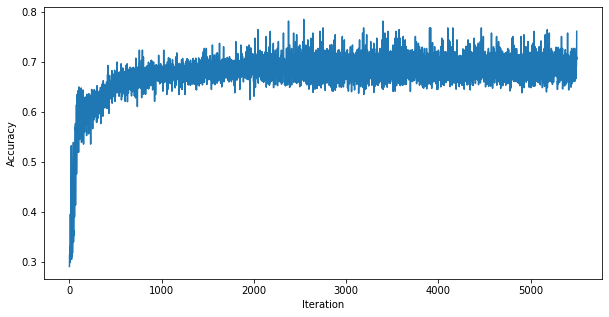

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

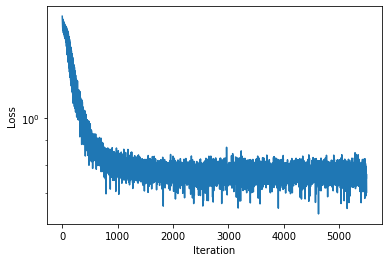

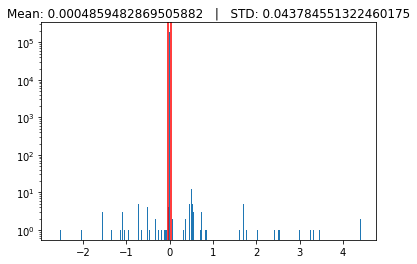

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 7.767857142857143


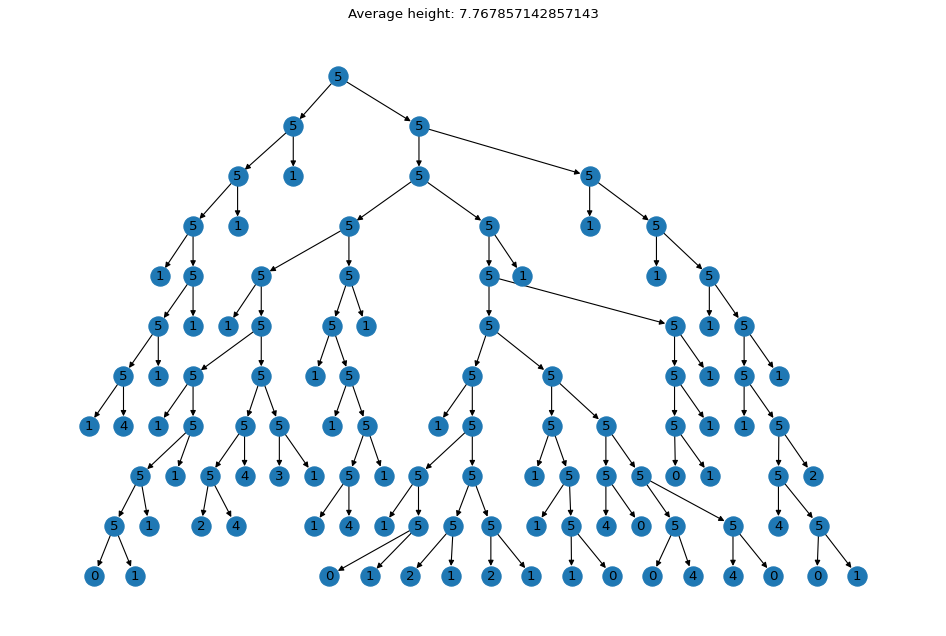

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 56


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============


/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25 ==============
============== Pattern 26 ==============
============== Pattern 27 ==============
============== Pattern 28 ==============
============== Pattern 29 ==============
============== Pattern 30 ==============
============== Pattern 31 ==============
============== Pattern 32 ==============
============== Pattern 33 ==============
============== Pattern 34 ==============
============== Pattern 35 ==============
============== Pattern 36 ==============
============== Pattern 37 ==============
============== Pattern 38 ==============
============== Pattern 39 ==============
============== P

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()